# Neural-network based inversion of magnetotelluric data

In [49]:
import math 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Define a function that calculates synthetic magnetotelluric data for a layered model. Takes calculation frequencies, layer thicknesses in meters and layer resistivities, returns complex impedace.

In [50]:
def MT1D(frequencies, thicknesses, resistivities):
     Z = 1.0j* np.zeros(len(frequencies))
     for f in range(0,len(frequencies)):      
         freq = frequencies[f]   
         omegamu = -1.0j * math.pi**2 * 8.0e-7 * freq
         sigmacurr = 1.0/ resistivities[len(resistivities)-1]
         kcurr = np.sqrt(omegamu * sigmacurr)
         alpha = 1.0j*np.zeros(len(thicknesses))        
         for index in range(len(resistivities)-2,-1,-1):
                sigmalow = 1.0 / resistivities[index + 1]
                sigmacurr = 1.0 / resistivities[index]
                kcurr = np.sqrt(omegamu * sigmacurr)
                klow = np.sqrt(omegamu * sigmalow)
                if (np.real(kcurr) < 0.0):
                    kcurr = -1.0 * kcurr
                    klow = -1.0 * klow                  
                xi = omegamu * (sigmacurr - sigmalow) / (kcurr + klow)**2
                alpha[index + 1] = (xi + alpha[index + 1]) / (1. + xi * alpha[index + 1])
                alpha[index] = alpha[index + 1] * np.exp(-2. * kcurr * thicknesses[index])
     
         adm = kcurr / (-1.0j * 2. * math.pi * freq) * ((1.- alpha[0]) / (1. + alpha[0]))
         Z[f]= np.conj(1. /adm) * 4.0e-7 * math.pi
     return Z;
 

Create a training dataset and test dataset based on two layer models with known thickness and random resistivities. The data will be the input and the models the reference output for the neural network.

In [62]:
freq = np.array([100, 10, 1, 0.1, 0.01] )
thick = np.array([1000, 10000]    )
def MakeData():

  nsamples = 500
  data = np.zeros([nsamples,2 * freq.size])
  models = np.zeros([nsamples,thick.size])
  for i in range(nsamples):
    res = np.exp(5 * np.random.rand(thick.size))
    models[i,:] = np.log(res)
    Z = MT1D(freq,thick,res)
    data[i,::2] = np.divide(Z.real,  np.sqrt(freq))
    data[i,1::2] = np.divide(Z.imag,  np.sqrt(freq))
    
  ntrain = 400
  x_train = data[:ntrain,:]
  y_train = models[:ntrain,:]
  x_test = data[ntrain:,:]
  y_test = models[ntrain:,:]
  return x_train, y_train, x_test, y_test

Plot a sample of the training data and histograms of all inputs and outputs.

## Questions
- What kind of distributions do you observe?
- What implications do these distributions have for training the neural network?

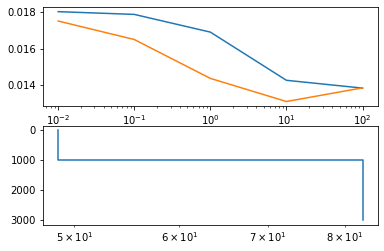

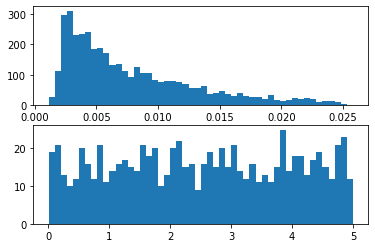

In [63]:
x_train, y_train, x_test, y_test = MakeData()

plt.figure()
plt.subplot(211)
plt.semilogx(freq,x_train[0,::2])
plt.semilogx(freq,x_train[0,1::2])
plt.subplot(212)
plt.semilogx(np.exp([y_train[0,0],y_train[0,0],y_train[0,1],y_train[0,1]]),[0,1000,1000,3000])
plt.gca().invert_yaxis()
plt.show()
plt.figure()
plt.subplot(211)
plt.hist(x_train.flatten(),bins=50)
plt.subplot(212)
plt.hist(y_train.flatten(),bins=50)
plt.show()

Now we create a neural network. The default is a random amalgamation of different activation functions and their associated initializers. The main reason for this is to provide a repository for the different options.

In [64]:
model = keras.Sequential(
    [keras.Input(shape=(x_train.shape[1],)),
     layers.Dense(100, activation='selu', kernel_initializer="lecun_normal")  ,
     layers.Dense(100, activation='relu', kernel_initializer="he_normal")  ,
     layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3), kernel_initializer="he_normal")  ,
     layers.Dense(y_train.shape[1], activation="sigmoid",kernel_initializer="glorot_normal")
     ]
    )

model.summary()
# Call model on a test input

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError())
h = model.fit(x_train, y_train, epochs=100)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_32 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 0s 827us/step - loss: 5.3968
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 4.5062
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4274
Epoch 

13/13 [==============================] - 0s 1ms/step - loss: 4.4103
Epoch 92/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4103
Epoch 93/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4103
Epoch 94/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4103
Epoch 95/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4103
Epoch 96/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4103
Epoch 97/100
13/13 [==============================] - 0s 994us/step - loss: 4.4103
Epoch 98/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4103
Epoch 99/100
13/13 [==============================] - 0s 935us/step - loss: 4.4103
Epoch 100/100
13/13 [==============================] - 0s 1ms/step - loss: 4.4103


Calculate and print the prediction misfit for the test and training data.

In [54]:
etest = model.evaluate(x_train, y_train)
etrain = model.evaluate(x_test, y_test)
print (etest)
print (etrain)


4/4 [==============================] - 0s 835us/step - loss: 3.9663
4.278365612030029
3.9663314819335938
{'verbose': 1, 'epochs': 100, 'steps': 13}


Plot the output of the neural network against the true value for each layer. What would indicate a good result?

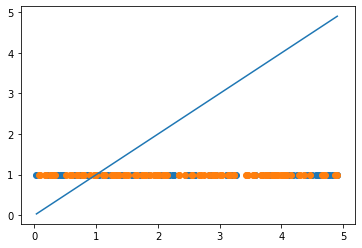

In [55]:
pred = model.predict(x_test)
plt.figure()
plt.scatter(y_test[:,0],pred[:,0])
plt.scatter(y_test[:,1],pred[:,1])
plt.plot([np.min(y_test[:,0]),np.max(y_test[:,0])],[np.min(y_test[:,0]),np.max(y_test[:,0])])
plt.show()

## Tasks
- Prepare the input and output data that it is more amenable to neural network training
- Find the simplest neural network that produces satisfactory results.